# Libraries and imports

In [ ]:
from google.colab import drive
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import glob
import cv2
import random
import matplotlib.image as mpimg
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from joblib import load
from imblearn.over_sampling import SMOTE
from google.colab import files
from joblib import dump
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import time
import joblib
import numpy as np
import seaborn as sns
from google.colab import files
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

Start with a T4 GPU Hardware accelerator, to use tensorflow for feature extraction using vgg16.  

# Data Preparation

**Import dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset in Google Drive as a zip folder.
The folder is unzipped and loaded into collab.**

In [ ]:
import os
import zipfile

zip_file = '/content/drive/MyDrive/TomatoPlantVillage.zip'
extracted_file = '/content/PlantVillage'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_file)

**Lists all the sub folders.**

Each sub-folder is a class

In [ ]:
os.listdir(extracted_file)

['TomatoPlantVillage']

In [ ]:
work_folder = '/content/PlantVillage/TomatoPlantVillage'
os.listdir(work_folder)

['Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot']

**Show class distribution (how many images each class contain), in a tabular form.**

In [ ]:
import pandas as pd

nums = {}
for class_dir in os.listdir(work_folder):
    dir_path = os.path.join(work_folder, class_dir)
    if os.path.isdir(dir_path):
        nums[class_dir] = len(os.listdir(dir_path))  # count files in directory

panda_classes = pd.DataFrame(list(nums.items()), columns=['Class', 'Number of Images'])

total_images = panda_classes['Number of Images'].sum()
panda_classes['Percentage'] = (panda_classes['Number of Images'] / total_images) * 100

# two decimal places
panda_classes['Percentage'] = panda_classes['Percentage'].apply(lambda x: f"{x:.2f}%")

panda_classes

,Class,Number of Images,Percentage
0,Tomato_Leaf_Mold,952,5.95%
1,Tomato_Early_blight,1000,6.25%
2,Tomato__Target_Spot,1404,8.77%
3,Tomato_Septoria_leaf_spot,1771,11.06%
4,Tomato_Late_blight,1909,11.92%
5,Tomato__Tomato_mosaic_virus,373,2.33%
6,Tomato_Spider_mites_Two_spotted_spider_mite,1676,10.47%
7,Tomato_healthy,1591,9.94%
8,Tomato__Tomato_YellowLeaf__Curl_Virus,3209,20.04%
9,Tomato_Bacterial_spot,2127,13.28%


<ipython-input-8-3d65bf971619>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Number of Images', data=panda_classes, palette='viridis')


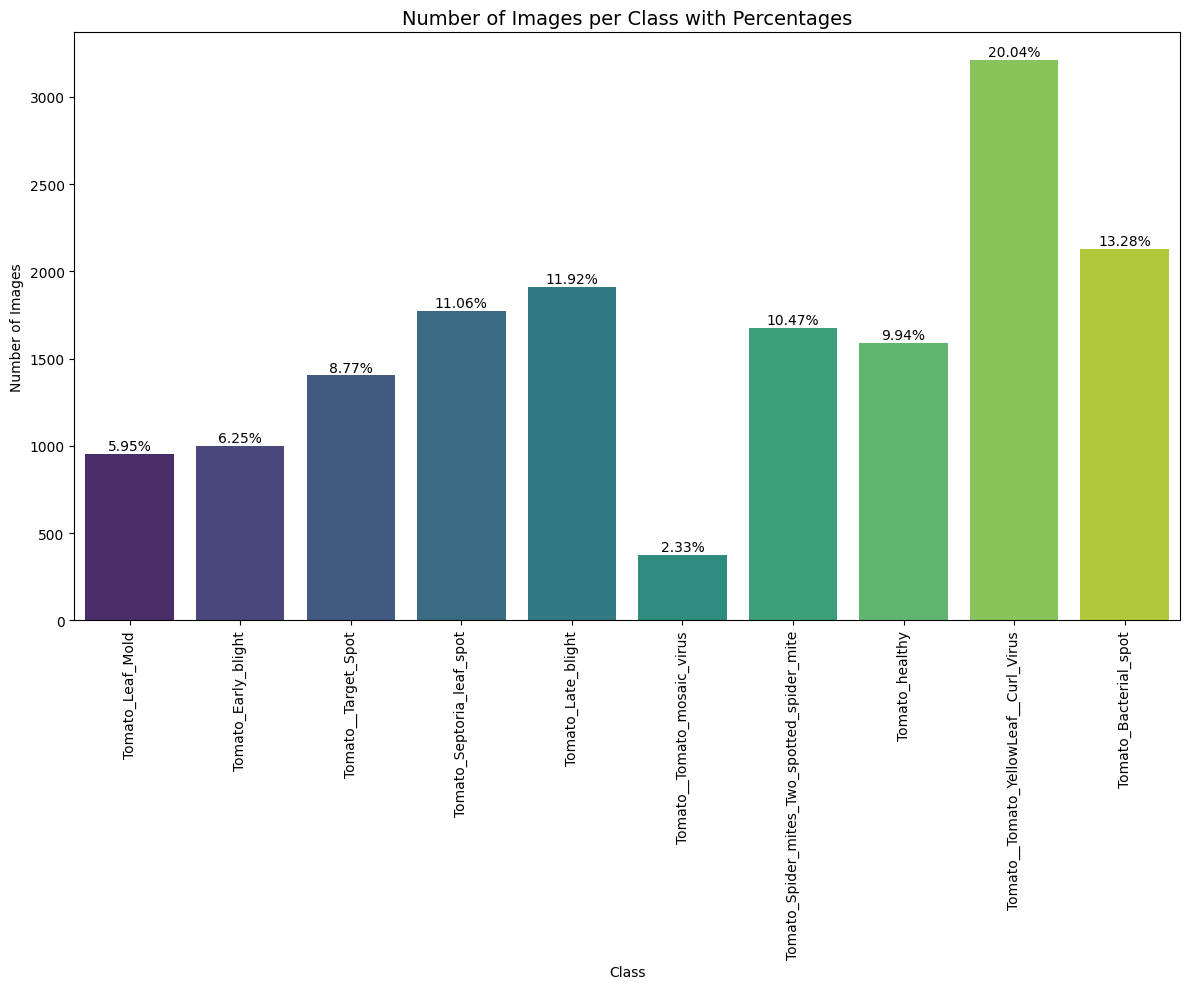

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.barplot(x='Class', y='Number of Images', data=panda_classes, palette='viridis')
for i, row in panda_classes.iterrows():
    plt.text(i, row['Number of Images'] + 5, row['Percentage'], ha='center', va='bottom', fontsize=10)

plt.title('Number of Images per Class with Percentages', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The class distribution is Imbalanced!

**Creates training and test sets directories**

In [ ]:
#destinations
split_dataset = "TomatoPlantDataset/"
train_path = os.path.join(split_dataset, "training_data")
test_path = os.path.join(split_dataset, "testing_data")

# make seperate directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

**Training and Testing sample splitting**

Training data is 80%

Testing data is 20%

In [ ]:
train_ratio = 0.80
test_ratio = 0.20

# function to split data
def datasplit(work_folder, train_path, test_path):

    # get class names
    class_names = os.listdir(work_folder)
    for cls in class_names:
        class_dir = os.path.join(work_folder, cls)
        images = os.listdir(class_dir)

        # split dataset
        train_val, testing_data = train_test_split(images, test_size=test_ratio, random_state=42)

        # copy images to dedicated directories
        for img in train_val:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, cls))
        for img in testing_data:
            shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, cls))

# create subdirectories for each class in train, val, test directories
for cls in os.listdir(work_folder):
    os.makedirs(os.path.join(train_path, cls), exist_ok=True)
    os.makedirs(os.path.join(test_path, cls), exist_ok=True)

# data split
datasplit(work_folder, train_path, test_path)

**Visualize one random image from each class of Training data**

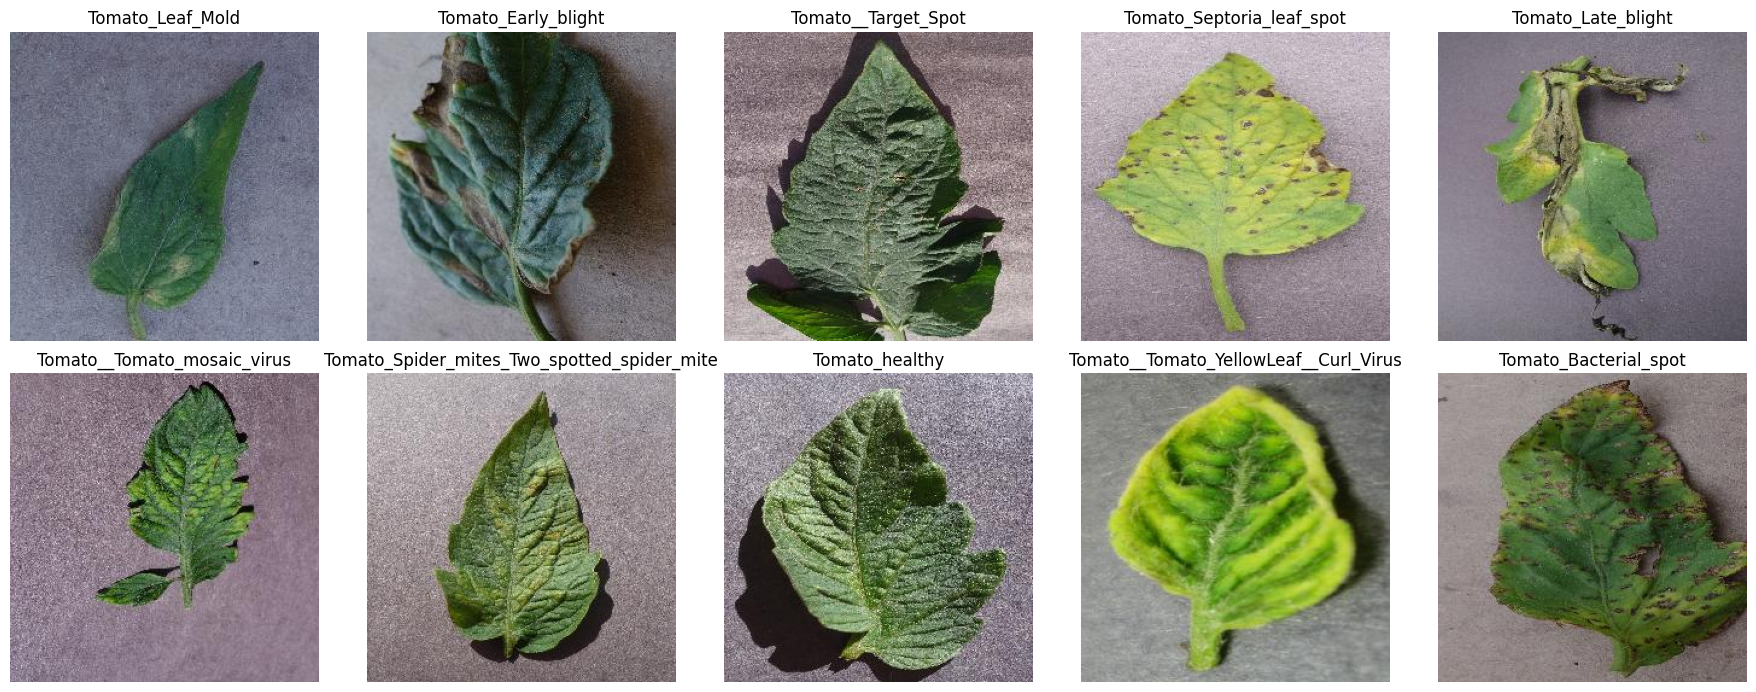

In [ ]:
# grid size
row = 2
col = 5

fig, axes = plt.subplots(row, col, figsize=(18, 7))  # image grid
axes = axes.flatten() # flatten axes array for indexing

# display one random image from each class
classes = os.listdir(train_path)
for i, class_name in enumerate(classes[:row*col]):  # rows*cols
    class_dir = os.path.join(train_path, class_name)

    # a random image from current class
    rand_img = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, rand_img)
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

https://github.com/bnsreenu/python_for_microscopists/blob/master/158b_transfer_learning_using_CNN_weights_VGG16_RF.py

**Capture training and testing data and their labels into respective lists**

In [ ]:
training_dir = '/content/TomatoPlantDataset/training_data'
testing_dir = '/content/TomatoPlantDataset/testing_data'
SIZE = 224  # fixed image size for transfer learning

In [ ]:
# training data and labels into respective lists
train_img = []
train_label = []
train_file_list = glob.glob(os.path.join(training_dir, "*"))

for dir_path in train_file_list:
    label = dir_path.split("\\")[-1]
    print(f"Processing Training Classe: {label}")

    cls_file_list = glob.glob(os.path.join(dir_path, "*.JPG"))
    for img_path in cls_file_list:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (SIZE, SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        train_img.append(image)
        train_label.append(label)

# convert lists to arrays
train_imgs = np.array(train_img)
train_labels = np.array(train_label)

# shape of the images and labels arrays
print(f"Number of training images: {train_imgs.shape[0]}")
print(f"Training labels: {train_labels}")

Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Leaf_Mold
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Early_blight
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato__Target_Spot
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Septoria_leaf_spot
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Late_blight
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato__Tomato_mosaic_virus
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Spider_mites_Two_spotted_spider_mite
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_healthy
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato__Tomato_YellowLeaf__Curl_Virus
Processing Training Classe: /content/TomatoPlantDataset/training_data/Tomato_Bacterial_spot
Number of training images: 12686
Training labels: [

In [ ]:
# test data and labels into respective lists
test_img = []
test_label = []
test_file_list = glob.glob(os.path.join(testing_dir, "*"))

for dir_path in test_file_list:
    label = dir_path.split("\\")[-1]
    print(f"Processing Testing Class: {label}")

    cls_file_list = glob.glob(os.path.join(dir_path, "*.JPG"))
    for img_path in cls_file_list:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (SIZE, SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        test_img.append(image)
        test_label.append(label)

test_imgs = np.array(test_img)
test_labels = np.array(test_label)

print(f"Number of testing images: {test_imgs.shape[0]}")
print(f"Testing labels: {test_labels}")

Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Leaf_Mold
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Early_blight
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato__Target_Spot
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Septoria_leaf_spot
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Late_blight
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato__Tomato_mosaic_virus
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Spider_mites_Two_spotted_spider_mite
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_healthy
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato__Tomato_YellowLeaf__Curl_Virus
Processing Testing Class: /content/TomatoPlantDataset/testing_data/Tomato_Bacterial_spot
Number of testing images: 3171
Testing labels: ['/content/TomatoPlantDataset/test

**Encode class labels from text to integers**

In [ ]:
# encoding labels to integers
label_encode = preprocessing.LabelEncoder()

label_encode.fit(train_labels)
train_encoded = label_encode.transform(train_labels)

label_encode.fit(test_labels)
test_encoded = label_encode.transform(test_labels)

print(f"Training labels: {train_encoded}")
print(f"Testing labels: {test_encoded}")

Training labels: [3 3 3 ... 0 0 0]
Testing labels: [3 3 3 ... 0 0 0]


In [ ]:
print(dict(zip(label_encode.classes_, label_encode.transform(label_encode.classes_))))

{'/content/TomatoPlantDataset/testing_data/Tomato_Bacterial_spot': 0, '/content/TomatoPlantDataset/testing_data/Tomato_Early_blight': 1, '/content/TomatoPlantDataset/testing_data/Tomato_Late_blight': 2, '/content/TomatoPlantDataset/testing_data/Tomato_Leaf_Mold': 3, '/content/TomatoPlantDataset/testing_data/Tomato_Septoria_leaf_spot': 4, '/content/TomatoPlantDataset/testing_data/Tomato_Spider_mites_Two_spotted_spider_mite': 5, '/content/TomatoPlantDataset/testing_data/Tomato__Target_Spot': 6, '/content/TomatoPlantDataset/testing_data/Tomato__Tomato_YellowLeaf__Curl_Virus': 7, '/content/TomatoPlantDataset/testing_data/Tomato__Tomato_mosaic_virus': 8, '/content/TomatoPlantDataset/testing_data/Tomato_healthy': 9}


In [ ]:
# defined split data
X_train, y_train, X_test, y_test = train_imgs, train_encoded, test_imgs, test_encoded

**Normalization of training and test data**

In [ ]:
# normalize pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Feature Extraction

**Load VGG16 Model with pre-trained weights**

In [ ]:
# https://stackoverflow.com/questions/65851403/vgg16-with-other-input-shape-and-imagenet-weights
# https://www.youtube.com/watch?v=Fxy6WTnUIww

# VGG16 with pre-trained weights and without fully connected layer
vgg16_feature_extractor = VGG16(include_top=False,
                   input_shape=(SIZE, SIZE, 3),
                   weights='imagenet')

# loaded layers as non-trainable
for layer in vgg16_feature_extractor.layers:
	  layer.trainable = False

vgg16_feature_extractor.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

uses about 24GB system RAM

**GPU setup for feature extraction using VGG16**

In [ ]:
import tensorflow as tf
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings and info logs
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


**Feature Extraction**

In [ ]:
import time

start_time = time.time()

with tf.device('/GPU:0'):
  train_fx = vgg16_feature_extractor.predict(X_train, batch_size=15)
  test_fx = vgg16_feature_extractor.predict(X_test, batch_size=15)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

846/846 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step
Time taken: 109.08810329437256 seconds


Feature extraction uses about 13.7 RAM out of 15 in the GPU (T4).
startup 42GB, training 32GB, test 28GB System RAM

**Get feature map dimentions**

In [ ]:
print(train_fx.shape)
print(test_fx.shape)

(12683, 7, 7, 512)
(3174, 7, 7, 512)


**Flatten features to 2D format**

In [ ]:
# flatten to 2D
train_fx_flat = train_fx.reshape(train_fx.shape[0], -1)
test_fx_flat = test_fx.reshape(test_fx.shape[0], -1)

print(train_fx_flat.shape)
print(test_fx_flat.shape)

(12683, 25088)
(3174, 25088)


In [ ]:
# download before changing the runtime to save computational resources/or if error occurs

# dump(train_fx_flat, 'train_fx_flat.pkl') # , compress=('zlib', 3)
# dump(test_fx_flat, 'test_fx_flat.pkl')
# dump(y_train, 'y_train.pkl')
# dump(y_test, 'y_test.pkl')

# files.download('train_fx_flat.pkl')
# files.download('test_fx_flat.pkl')
# files.download('y_train.pkl')
# files.download('y_test.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest Model Training

Before starting this step, the Run time is switched to High CPU RAM, because PCA/SMOTE takes substantial amount of system RAM. To be able to use multiple computing sessions, and to avoid runtime disconnection, the data is reloaded.

In [ ]:
X_train_flat = load('train_fx_flat.pkl')
y_train_load = load('y_train.pkl')
X_test_flat = load('test_fx_flat.pkl')
y_test_load = load('y_test.pkl')

In [ ]:
X_train_flat.shape

(12683, 25088)

**Oversample the classes in training data to balance the classes**

In [ ]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

smote = SMOTE(sampling_strategy='auto', random_state=42)
train_resample, y_train_res = smote.fit_resample(X_train_flat, y_train_load)

print(f"Resampled class distribution: {dict(zip(*np.unique(y_train_res, return_counts=True)))}")
print(f"Resampled data shape: {train_resample.shape}")

Resampled class distribution: {0: 2566, 1: 2566, 2: 2566, 3: 2566, 4: 2566, 5: 2566, 6: 2566, 7: 2566, 8: 2566, 9: 2566}
Resampled data shape: (25660, 25088)


sys ram 6.3/51.GB

In [ ]:
dump(y_train_res, 'y_train_res.pkl')
files.download('y_train_res.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dimentionality Reduction

In [ ]:
pca = PCA()

start_time = time.time()
pca.fit(train_resample)
end_time = time.time()
print(f"Time taken to fit PCA: {end_time - start_time} seconds")

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"PCA components for 95% variance: {d}")

Time taken to fit PCA: 1920.1263477802277 seconds
PCA components for 95% variance: 2420


sys 17.4/51 GB

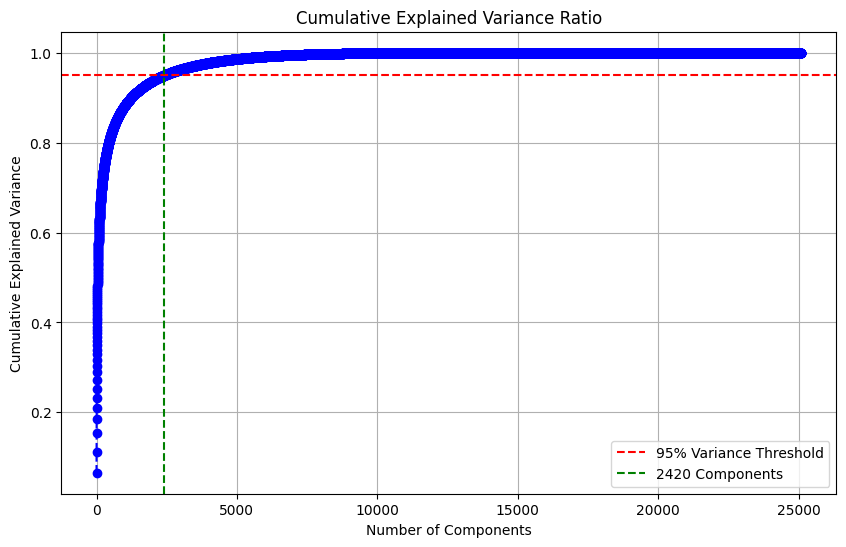

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumsum, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=d, color='g', linestyle='--', label=f'{d} Components')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# dimensionality reduction with PCA
pca = PCA(n_components=d)

start_time = time.time()
X_train_pcad = pca.fit_transform(train_resample)
X_test_pcad = pca.transform(X_test_flat)
end_time = time.time()
print(f"Time taken to perform PCA: {end_time - start_time} seconds")

print(X_train_pcad.shape)
print(X_test_pcad.shape)

Time taken to perform PCA: 261.76681089401245 seconds
(25660, 2420)
(3174, 2420)


In [ ]:
dump(X_train_pcad, 'X_train_pcad.pkl', compress=('zlib', 3))
dump(X_test_pcad, 'X_test_pcad.pkl', compress=('zlib', 3))

files.download('X_train_pcad.pkl')
files.download('X_test_pcad.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

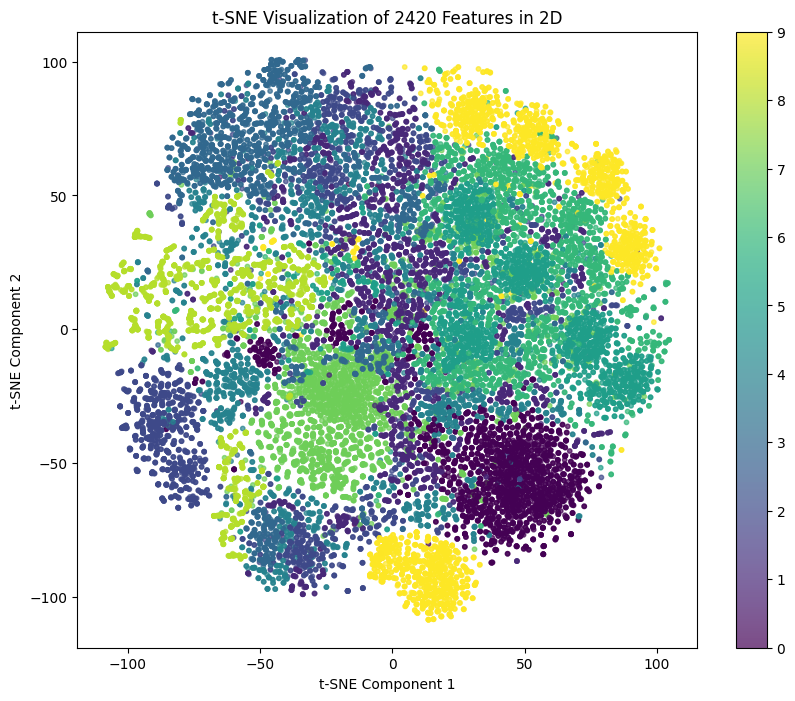

In [ ]:
d_dim = X_train_pcad
tsne = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne.fit_transform(d_dim)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_train_res, cmap='viridis', s=10, alpha=0.7)
plt.title('t-SNE Visualization of 2420 Features in 2D')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

In [ ]:
X_train_pcad = load('X_train_pcad.pkl')
X_test_pcad = load('X_test_pcad.pkl')
y_train_res = load('y_train_res.pkl')
y_test_load = load('y_test.pkl')

# Default Model Training, validation, Testing

**Train model with Default parameters**

In [ ]:
training_data, val_data, training_labels, val_labels = train_test_split(X_train_pcad,
                                                                        y_train_res,
                                                                        test_size=0.15,
                                                                        random_state=42,
                                                                        stratify=y_train_res)

rf_classifier = RandomForestClassifier(random_state=42)  # default rf

start = time.time()
rf_classifier.fit(training_data, training_labels)
end = time.time()
print(f"Training Time: {end - start}")
train_pred = rf_classifier.predict(training_data)
train_accuracy = accuracy_score(training_labels, train_pred)
print(f"Training Accuracy: {train_accuracy}")

val_pred = rf_classifier.predict(val_data)
val_accuracy = accuracy_score(val_labels, val_pred)
print(f"Validation Accuracy: {val_accuracy}")

test_pred = rf_classifier.predict(X_test_pcad)
test_acc = accuracy_score(y_test_load, test_pred)
print(f"Test Accuracy: {test_acc}")

Training Time: 128.5628638267517
Training Accuracy: 1.0
Validation Accuracy: 0.8901013250194856
Test Accuracy: 0.6531190926275993


In [ ]:
# joblib.dump(rf_classifier, 'RandomForest_default_model.pkl')
# files.download('RandomForest_default_model.pkl')

# Hyperparameter tuning to decide a search space for experiments

In [ ]:
# https://medium.com/@prabowoyogawicaksana/hyperparameter-optimization-random-forest-classifier-550fd5ed8e14

hyp_param_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=5)],
    'max_features': ['sqrt','log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 50, 5)],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True],
    'criterion':['gini']
}

# stratified K-Fold cross-validator
strat_kfold_rf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

rf_model = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(estimator=rf_model,
                                    param_distributions=hyp_param_rf,
                                    n_iter=6,
                                    cv=strat_kfold_rf,
                                    random_state=42,
                                    n_jobs=5, # uses 5 out of 8 CPUs
                                    verbose=2)

start_time = time.time()
rf_rand_search.fit(X_train_pcad, y_train_res)
end_time = time.time()
print(f"Time taken to Train the best RF mode using Random Seacrch: {end_time - start_time} seconds")

print(f"Best Hyperparameter: {rf_rand_search.best_params_}")
print(f"Best Cross-Validation Score: {rf_rand_search.best_score_}")

best_rf_model = rf_rand_search.best_estimator_

joblib.dump(best_rf_model, 'RandomForest_best_model.pkl')
files.download('RandomForest_best_model.pkl')

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Time taken to Train the best RF mode using Random Seacrch: 19605.260795354843 seconds
Best Hyperparameter: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}
Best Cross-Validation Score: 0.8877240841777085


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Experiments

Uses same parameters found by random search.

only n_estimators and max depth are adjusted




In [ ]:
def rf_experiment(n_estimators, max_depth, trial_id=1):

    training_data, val_data, training_labels, val_labels = train_test_split(X_train_pcad,
                                                                          y_train_res,
                                                                          test_size=0.15,
                                                                          random_state=42,
                                                                          stratify=y_train_res)

    print(f"Training with: n_estimators={n_estimators}, max_depth={max_depth}")

    # other parameters are same as the best hyperparameters
    rf_classifier_ex = RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=5,
                                              min_samples_leaf=2,
                                              max_features='sqrt',
                                              bootstrap=True,
                                              criterion='gini',
                                              random_state=42)


    start = time.time()
    rf_classifier_ex.fit(training_data, training_labels)
    end = time.time()
    print(f"Training Time: {end - start}")

    # this chunk of code is added later: after conducting Experiment 1 to 3
    train_pred = rf_classifier_ex.predict(training_data)
    train_accuracy = accuracy_score(training_labels, train_pred)
    print(f"Training Accuracy: {train_accuracy}")
    #-----------------------------------------------------------------------

    # validation accuracy
    val_pred = rf_classifier_ex.predict(val_data)
    val_accuracy = accuracy_score(val_labels, val_pred)
    print(f"Validation Accuracy: {val_accuracy}")

    # test accuracy
    test_pred = rf_classifier_ex.predict(X_test_pcad)
    test_acc = accuracy_score(y_test_load, test_pred)
    print(f"Test Accuracy: {test_acc}")

    # trial model download
    model_filename = f"rf_model_trial_{trial_id}.pkl"
    joblib.dump(rf_classifier_ex, model_filename)

    return val_accuracy, test_acc, model_filename



**Test 1**

In [ ]:
results = []

results.append(rf_experiment(n_estimators=100, max_depth=30, trial_id=1))
results.append(rf_experiment(n_estimators=200, max_depth=30, trial_id=2))
results.append(rf_experiment(n_estimators=300, max_depth=30, trial_id=3))
results.append(rf_experiment(n_estimators=400, max_depth=30, trial_id=4))
results.append(rf_experiment(n_estimators=500, max_depth=30, trial_id=5))

for result in results:
  val_accuracy, test_accuracy, model_filename = result
  print(f"Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}, Model Filename: {model_filename}")


Training with: n_estimators=100, max_depth=30
Training Time: 123.83118772506714
Validation Accuracy: 0.8934788256690049
Test Accuracy: 0.6805293005671077
Training with: n_estimators=200, max_depth=30
Training Time: 246.79244017601013
Validation Accuracy: 0.9238763315146792
Test Accuracy: 0.7199117832388153
Training with: n_estimators=300, max_depth=30
Training Time: 371.2728810310364
Validation Accuracy: 0.9269940244219278
Test Accuracy: 0.7460617517328293
Training with: n_estimators=400, max_depth=30
Training Time: 494.71206498146057
Validation Accuracy: 0.9306313328137179
Test Accuracy: 0.7523629489603024
Training with: n_estimators=500, max_depth=30
Training Time: 617.0957381725311
Validation Accuracy: 0.9368667186282151
Test Accuracy: 0.7687460617517329
Validation Accuracy: 0.8934788256690049, Test Accuracy: 0.6805293005671077, Model Filename: rf_model_trial_1.pkl
Validation Accuracy: 0.9238763315146792, Test Accuracy: 0.7199117832388153, Model Filename: rf_model_trial_2.pkl
Valida

**Test 2**

In [ ]:
results2 = []

results2.append(rf_experiment(n_estimators=100, max_depth=10, trial_id=6))
results2.append(rf_experiment(n_estimators=100, max_depth=30, trial_id=7))
results2.append(rf_experiment(n_estimators=100, max_depth=50, trial_id=8))
results2.append(rf_experiment(n_estimators=100, max_depth=70, trial_id=9))
results2.append(rf_experiment(n_estimators=100, max_depth=90, trial_id=10))
results2.append(rf_experiment(n_estimators=100, max_depth=110, trial_id=11))

for result in results2:
  val_accuracy, test_accuracy, model_filename = result
  print(f"Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}, Model Filename: {model_filename}")


Training with: n_estimators=100, max_depth=10
Training Time: 90.84973788261414
Validation Accuracy: 0.8581449727201871
Test Accuracy: 0.7088846880907372
Training with: n_estimators=100, max_depth=30
Training Time: 133.732750415802
Validation Accuracy: 0.8934788256690049
Test Accuracy: 0.6805293005671077
Training with: n_estimators=100, max_depth=50
Training Time: 136.01477313041687
Validation Accuracy: 0.8960769030917122
Test Accuracy: 0.6830497794580971
Training with: n_estimators=100, max_depth=70
Training Time: 134.93828749656677
Validation Accuracy: 0.8960769030917122
Test Accuracy: 0.6830497794580971
Training with: n_estimators=100, max_depth=90
Training Time: 134.7545313835144
Validation Accuracy: 0.8960769030917122
Test Accuracy: 0.6830497794580971
Training with: n_estimators=100, max_depth=110
Training Time: 132.64608907699585
Validation Accuracy: 0.8960769030917122
Test Accuracy: 0.6830497794580971
Validation Accuracy: 0.8934788256690049, Test Accuracy: 0.6805293005671077, Mod

Trial 5 shows best performance so far

**Test 3**

started at 17:08h

In [ ]:
results3 = []

results3.append(rf_experiment(n_estimators=2000, max_depth=10, trial_id=12))
results3.append(rf_experiment(n_estimators=5000, max_depth=10, trial_id=13))
results3.append(rf_experiment(n_estimators=15000, max_depth=10, trial_id=14))
results3.append(rf_experiment(n_estimators=20000, max_depth=10, trial_id=15))

Training with: n_estimators=2000, max_depth=10
Training Time: 1744.6328675746918
Validation Accuracy: 0.9051701740711873
Test Accuracy: 0.7885948330182735
Training with: n_estimators=5000, max_depth=10
Training Time: 4373.062614917755
Validation Accuracy: 0.9085476747207066
Test Accuracy: 0.7908002520478891
Training with: n_estimators=15000, max_depth=10
Training Time: 13173.856691360474
Validation Accuracy: 0.908287866978436
Test Accuracy: 0.795526149968494
Training with: n_estimators=20000, max_depth=10


**Test 4**

including training accuracy**

In [ ]:
result4 = []

result4.append(rf_experiment(n_estimators=10000, max_depth=10, trial_id=16))

for result in result4:
  val_accuracy, test_accuracy, model_filename = result
  print(f"training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}, Model Filename: {model_filename}")

Training with: n_estimators=10000, max_depth=10
Training Time: 13709.233087539673
Training Accuracy: 0.995781944890193
Validation Accuracy: 0.9069888282670824
Test Accuracy: 0.796471329552615


NameError: name 'train_accuracy' is not defined

In [ ]:
# download best model
final_model = joblib.load('rf_model_trial_16.pkl')

# Evaluation

**Confusion Matrix**

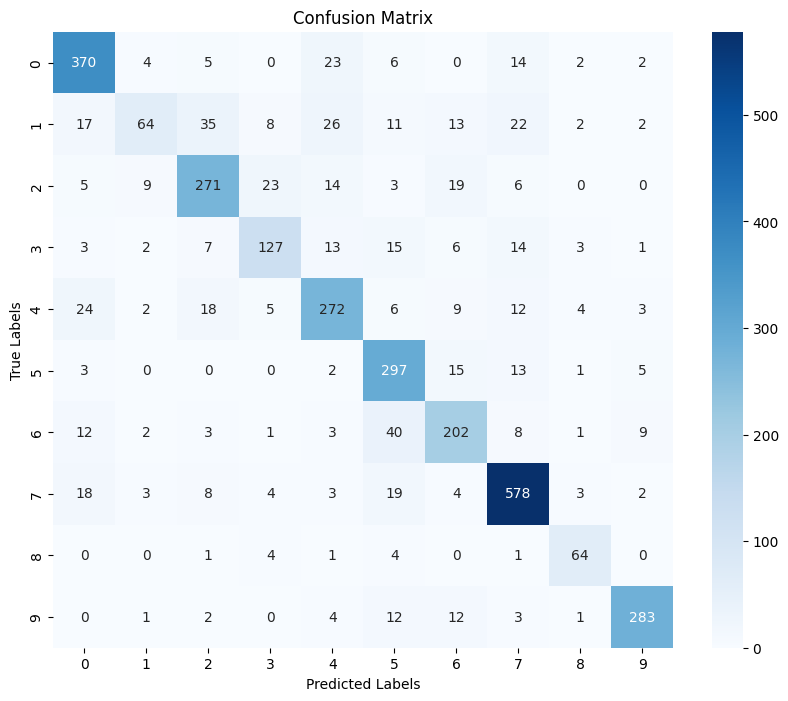

In [ ]:
y_predict = final_model.predict(X_test_pcad)

cm = confusion_matrix(y_test_load, y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_test_load, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       426
           1       0.74      0.32      0.45       200
           2       0.77      0.77      0.77       350
           3       0.74      0.66      0.70       191
           4       0.75      0.77      0.76       355
           5       0.72      0.88      0.79       336
           6       0.72      0.72      0.72       281
           7       0.86      0.90      0.88       642
           8       0.79      0.85      0.82        75
           9       0.92      0.89      0.91       318

    accuracy                           0.80      3174
   macro avg       0.78      0.76      0.76      3174
weighted avg       0.80      0.80      0.79      3174

